In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [8]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)
torch.cuda.current_device()
# torch.cuda.is_available()
# torch.cuda.device_count()

The code will run on GPU.


0

We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [9]:
data_path = '/zhome/25/e/155273/Desktop/02516_dvcv/02516_intro_cnn/hotdog_nothotdog' #mkl
data_path = '/home/mlut/IDLCV/dtu/datasets1/02516/hotdog_nothotdog' #mlu

class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=data_path):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [10]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
size = 128

# Augmented training transformations
train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),      # Randomly rotate the images by 10 degrees
    transforms.RandomCrop(size, padding=10),  # Randomly crop a portion of the image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor()
])

# Test transformations (without data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
])

batch_size = 64

# Load the augmented training dataset
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
 

print(len(trainset))
spl= int(len(trainset)/3)

trainset, val_dataset = random_split(trainset, (len(trainset)-spl, spl))
print('TRAIN video number: {}, VAL video number: {}.'.format(len(trainset), len(val_dataset)))
 


train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=3)

# Load the test dataset (without augmentation)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

foo, _ = next(iter(test_loader))
# print(foo.unsqueeze(1))

# print(target.unsqueeze(1))

2047
TRAIN video number: 1365, VAL video number: 682.


Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

Let's look at some images from our data 

torch.Size([64, 3, 128, 128])
tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.9804, 0.9804, 0.9922,  ..., 0.0000, 0.0000, 0.0000],
          [0.3255, 0.3137, 0.3059,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4627, 0.4784, 0.4863,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.9765, 0.9765, 0.9804,  ..., 0.0000, 0.0000, 0.0000],
          [0

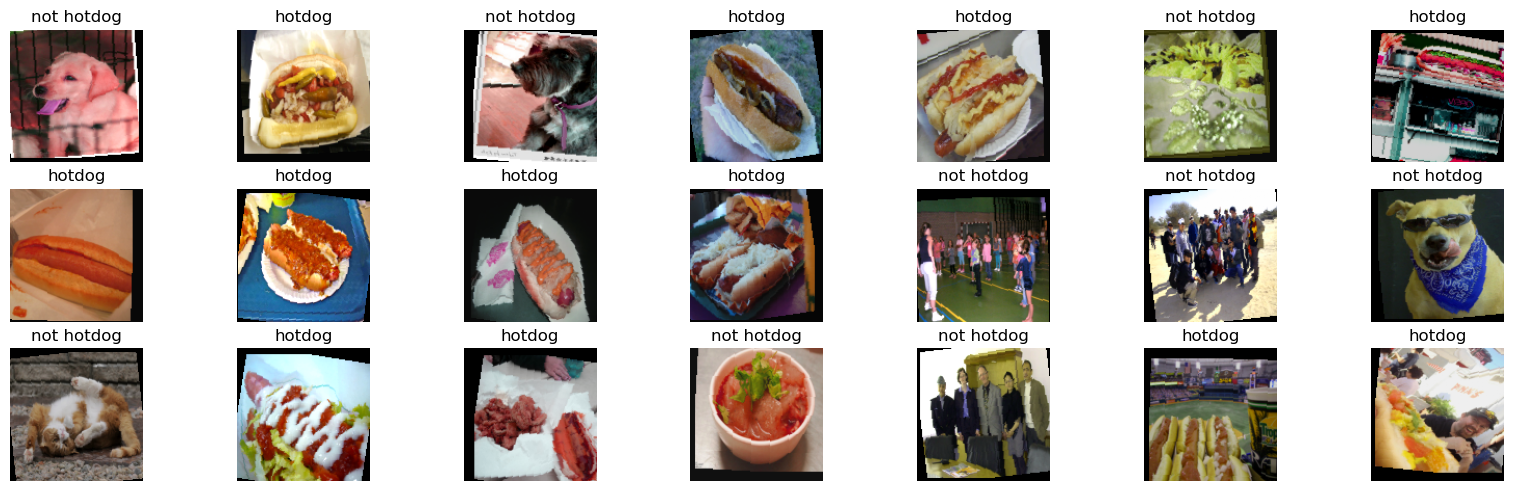

In [11]:
images, labels = next(iter(train_loader))
print(images.shape) #(64,3,128,128) ? 
print(images)
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [12]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Now create a model and train it!


In [13]:
class Network02(nn.Module):
    def __init__(self):
        super(Network02, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 2**3, kernel_size=3, padding=0), #127
                nn.ReLU(),
                # nn.MaxPool2d(2, stride=2), #127/2 = 63
                nn.Conv2d(2**3, 2**4, kernel_size=3, padding=0), # 126
                nn.BatchNorm2d(2**4), #should return 62 ?? 
                nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(16*124*124, 124*124),
                nn.ReLU(),
                nn.Linear(124*124, 500),
                nn.ReLU(),
                nn.Linear(500, 250),
                nn.ReLU(),
                nn.Linear(250, 125),
                nn.ReLU(),
                nn.Linear(125, 1)
        )
        # self.sigmoid = 
    def forward(self, x):
        x = self.convolutional(x)        
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        # x = nn.F.sigmoid(x)
        # x = nn.Softmax(dim=1)(x)
        return x

In [14]:
class Network03(nn.Module):
    def __init__(self):
        super(Network03, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 2**3, kernel_size=3, padding=0), #start with a resolution of 128, after conv, 126
                nn.Conv2d(2**3, 2**4, kernel_size=3, padding=0), # 126 input, output 124,
                #nn.ReLU()
                nn.MaxPool2d(2, stride=2), #max pool, leaves 62 
                nn.BatchNorm2d(2**4), 
                nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(16*62*62, 124*124),
                nn.ReLU(),
                nn.Linear(124*124, 500),
                nn.ReLU(),
                nn.Linear(500, 250),
                nn.ReLU(),
                nn.Linear(250, 125),
                nn.ReLU(),
                nn.Linear(125, 1)
        )
        # self.sigmoid = 
    def forward(self, x):
        x = self.convolutional(x)        
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        # x = nn.F.sigmoid(x)
        # x = nn.Softmax(dim=1)(x)
        return torch.sigmoid(x)

In [38]:
class Network04(nn.Module):
    def __init__(self):
        super(Network04, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.fully_connected = nn.Sequential(
            nn.Linear(in_features=128 * 61 * 61, out_features=512), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, x):
        x = self.convolutional(x)        
        x = x.view(x.size(0), -1)  
        x = self.fully_connected(x)
        return x



In [39]:
model = Network04()
model.to(device)
#Initialize the optimizer
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.0001)

#Get the first minibatc
data = next(iter(train_loader))[0].cuda()
print(data.shape)
# Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit
print("model works with one minibatch")

torch.Size([64, 3, 128, 128])
Shape of the output from the convolutional part torch.Size([64, 128, 61, 61])
model works with one minibatch


In [17]:
# Martins old evaluation loop commented out at 4/1-24 15:38 when Fatema showed better erformance
# import torch.optim as optim

# optimizer = optimizer_adam
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-5, patience=50, factor=0.1)
 

# num_epochs = 5
# loss_function = nn.BCEWithLogitsLoss()

# for epoch in tqdm(range(num_epochs), unit='epoch'):
#     model.train()  
#     train_correct = 0
#     for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = loss_function(output.squeeze(), target.float())  
#         loss.backward()
#         optimizer.step()
#         predicted = (output > 0).float()  # Connverts logits to 0s and 1s
#         train_correct += (target == predicted.squeeze()).sum().item()

#     model.eval()  # Set the model to evaluation mode
#     test_correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             predicted = (output > 0).float()  # Convert logits to 0s and 1s
#             test_correct += (target == predicted.squeeze()).sum().item()

#     train_acc = train_correct / len(trainset)
#     test_acc = test_correct / len(testset)
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_acc*100:.1f}%, Test Accuracy: {test_acc*100:.1f}%")
 

In [41]:
#MARTIN IS PLAYING
import torch.optim as optim

#optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = optimizer_adam
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-5, patience=50, factor=0.1)

#optimizer = optim.SGD(vcopn.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.wd)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-5, patience=50, factor=0.1)


num_epochs = 5
loss_function = nn.BCEWithLogitsLoss()

for epoch in tqdm(range(num_epochs), unit='epoch'):
    model.train()  
    train_correct = 0 
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output.squeeze(), target.float())  
        loss.backward()
        optimizer.step()
        
        predicted = (output > 0).float()  # Connverts logits to 0s and 1s
        train_correct += (target == predicted.squeeze()).sum().item()

    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    with torch.no_grad():
        for data, target in  val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output.squeeze(), target.float())  
      
            scheduler.step(loss)
            predicted = (output > 0).float()  # Convert logits to 0s and 1s
            val_correct += (target == predicted.squeeze()).sum().item()
            

    train_acc = train_correct / len(trainset)
    val_acc = val_correct / len(val_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_acc*100:.1f}%, val Accuracy: {val_acc*100:.1f}%")

 
test_correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        predicted = (output > 0).float()  # Convert logits to 0s and 1s
        test_correct += (target == predicted.squeeze()).sum().item()

 
test_acc = test_correct / len(testset)
print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {test_acc*100:.1f}%")


 

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/5, Train Accuracy: 64.2%, val Accuracy: 72.9%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/5, Train Accuracy: 67.9%, val Accuracy: 72.7%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/5, Train Accuracy: 65.3%, val Accuracy: 68.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4/5, Train Accuracy: 69.5%, val Accuracy: 69.9%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5/5, Train Accuracy: 68.6%, val Accuracy: 69.8%
Epoch 5/5, Test Accuracy: 72.3%


In [71]:
import torch
import numpy as np
import torch.nn.functional as F

def smoothgrad(model, input_image, target_class, stdev_spread=0.15, n_samples=25, magnitude=True):
    """
    Generate a SmoothGrad saliency map.
    
    :param model: The trained model (should be in evaluation mode).
    :param input_image: Input image tensor (should be normalized if the model expects normalized images).
    :param target_class: The target class for which to generate the saliency map.
    :param stdev_spread: Amount of noise to add to the input (as a fraction of the total range of the input).
    :param n_samples: The number of samples to use for averaging.
    :param magnitude: If True, return the magnitude of the gradient.
    
    :return: A numpy array representing the SmoothGrad saliency map.
    """
    model.eval()
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    input_image.requires_grad = True

    stdev = (input_image.max() - input_image.min()) * stdev_spread

    total_gradients = torch.zeros_like(input_image)
    for _ in range(n_samples):
        # Add noise to the image
        noise = torch.normal(mean=0, std=stdev, size=input_image.shape)
        noisy_image = input_image + noise

        # Forward pass
        output = model(noisy_image)
        model.zero_grad()

        # Target for backprop
        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1

        # Backward pass
        output.backward(gradient=one_hot_output)

        # Accumulate gradients
        if magnitude:
            total_gradients += input_image.grad.abs()
        else:
            total_gradients += input_image.grad

        # Zero gradients for the next iteration
        input_image.grad.zero_()

    # Average the gradients
    avg_gradients = total_gradients / n_samples

    # Convert to numpy for visualization
    avg_gradients = avg_gradients.squeeze().cpu().detach().numpy()
    
    return avg_gradients

# Example usage
# model = ...  # Your trained model
# input_image = ...  # Input image tensor
# target_class = ...  # Target class index

# Generate the saliency map
# saliency_map = smoothgrad(model, input_image, target_class)

# You can now visualize the saliency_map using visualization libraries like matplotlib


In [76]:

stdev = (images.max() - images.min()) * 0.15
noise = torch.normal(mean=0, std=stdev, size=images.shape)

In [74]:
saliency_map = smoothgrad(model, images, 0 )

TypeError: normal() received an invalid combination of arguments - got (size=torch.Size, std=Tensor, mean=int, ), but expected one of:
 * (Tensor mean, Tensor std, *, torch.Generator generator, Tensor out)
 * (Tensor mean, float std, *, torch.Generator generator, Tensor out)
 * (float mean, Tensor std, *, torch.Generator generator, Tensor out)
 * (float mean, float std, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


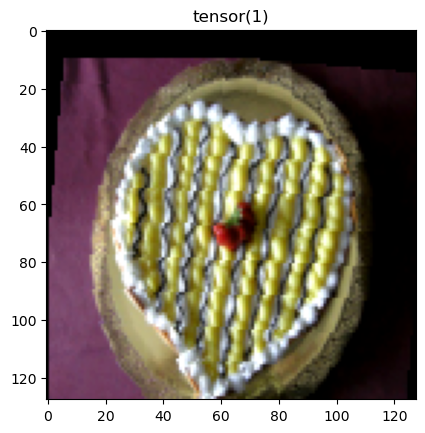

In [73]:
for images, labels in train_loader:
    plt.imshow(images[0].permute(1,2,0).squeeze(), cmap='gray')
    plt.title(labels[0])
    break


In [19]:
# optimizer = optimizer_adam
# num_epochs = 5
# loss_function = nn.BCEWithLogitsLoss()

# for epoch in tqdm(range(num_epochs), unit='epoch'):
#     #For each epoch
#     # train_correct = 
#     running_loss = 0
#     for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
#         data, target = data.to(device), target.to(device)
#         #Zero the gradients computed for each weight
#         optimizer.zero_grad()
#         #Forward pass your image through the network
#         output = model(data)
        
#         #Compute the loss
#         # output = output.view(output.size(0), -1)
#         # output = output[0]
#         # print(output.shape)
#         # print(target.shape)
#         # print(torch.log(output))
#         # loss = F.nll_loss(torch.log(output), target)
#         # loss = F.binary_cross_entropy(output, target)
#         loss = loss_function(output, target.unsqueeze(1).float())
#         #Backward pass through the network
#         loss.backward()
#         #Update the weights
#         optimizer.step()
#         running_loss += loss.item()
#         #Compute how many were correctly classified
#         predicted = (output > 0).float() #predicted = output.argmax(1) ## THIS IS WRONG; 
#         train_correct += (target == predicted.squeeze()).sum().item() #train_correct += (target==predicted).sum().cpu().item()
#     #Comput the test accuracy
#     test_correct = 0
#     for data, target in test_loader:
#         data = data.to(device)
#         with torch.no_grad():
#             output = model(data)
#         predicted = (output > 0).float() ## also changed here from argmax
#         test_correct += (target==predicted).sum().item()
#     train_acc = train_correct/len(trainset)
#     test_acc = test_correct/len(testset)
#     print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

<h1>Salient Maps</h1>

tensor([[0.0538]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(0.0538, device='cuda:0', grad_fn=<SelectBackward0>)


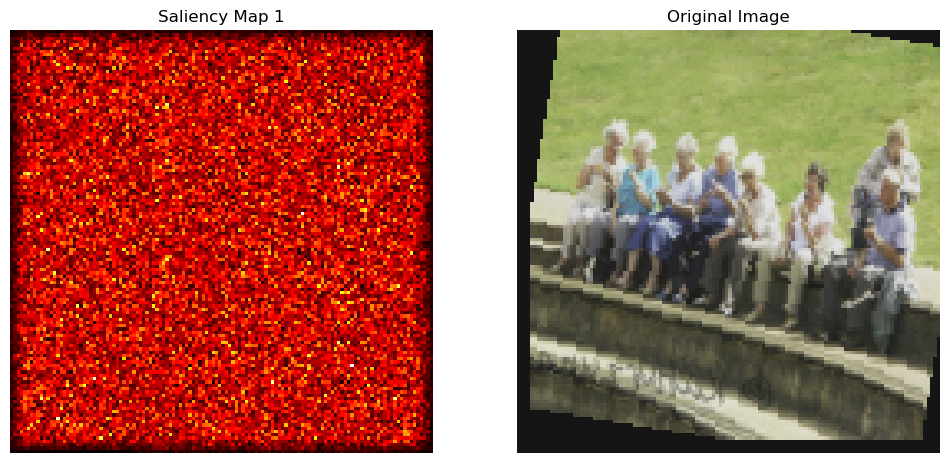

In [20]:


X = next(iter(train_loader))[0].to(device)
X = next(iter(train_loader))[0].to(device)
X = X[0].to(device) #get single shape
model = Network04()

# we would run the model in evaluation mode
model.to(device)

for param in model.parameters():
    param.requires_grad = False
model.eval()

X = X.unsqueeze(0)
# print(X.shape)
# print(X)
# print(X.shape)
X.requires_grad = True


scores = model(X)
print(scores)

# # Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]
print(score_max)

score_max.backward()

#ChatGPT coded some of this
saliency, _ = torch.max(X.grad.data.abs(),dim=1)
saliency = saliency.to('cpu')



fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first saliency map on the first subplot
axes[0].imshow(saliency[0], cmap=plt.cm.hot)
axes[0].axis('off')  # Hide the axis on the first subplot
axes[0].set_title('Saliency Map 1')  # Optional: Set a title for the first subplot

X = X.squeeze(0)
X = X.to('cpu')
# Plot the second saliency map on the second subplot
axes[1].imshow(np.swapaxes(np.swapaxes(X.detach().numpy(), 0, 2), 0, 1))
axes[1].axis('off')  # Hide the axis on the second subplot
axes[1].set_title('Original Image')  # Optional: Set a title for the second subplot

# Display the figure with both subplots
plt.show()

In [85]:
# Initialize the model
model = Network04()
model.eval()
model.to(device)

# Adjust single input and target to match each other
input_image, target = next(iter(train_loader))
input_image = input_image[0].unsqueeze(0).to(device)
# input_image = input_image.
input_image.requires_grad = True

output = model(input_image)

#Match target dtype and shape to output
target = target[0].view(-1,1)
target = target.float().view_as(output) #Target shape will match output shape
target = target.to(device)

# Calculate Loss and find input gradient by backpropagation
output_sig = torch.sigmoid(output)
loss = F.binary_cross_entropy(output_sig, target)
model.zero_grad()
loss.backward()

# Setup for display
gradient = input_image.grad.data

# Pool the gradients across the channels
pooled_gradients = torch.mean(gradient, dim=[0, 2, 3])


# A try at making a saliency map
saliency = torch.zeros_like(input_image).to(device)
for i in range(3):
    saliency[0, i, ...] = input_image[0, i, ...] * pooled_gradients[i]




#ormalize the saliency map
saliency_max = saliency.max()
saliency_min = saliency.min()

if saliency_max != saliency_min:
    saliency_normalized = (saliency - saliency_min) / (saliency_max - saliency_min)
else:
    saliency_normalized = saliency


saliency = saliency_normalized.to('cpu')
saliency_map = torch.abs(saliency).squeeze()
image = input_image.squeeze(0).to('cpu')

#Heatmap
heatmap = torch.abs(saliency).permute(1, 2, 0).detach().numpy()
heatmap = np.mean(heatmap, axis=2) # Convert to grayscaleu')


fig, axes = plt.subplots(3, 2, figsize=(12, 6))

# Plot the saliency map
axes[0].imshow(saliency_map.permute(1, 2, 0).detach().numpy())
axes[0].set_title('Saliency Map 1')  
axes[0].axis('off')


#Plot Image
axes[1].imshow(np.swapaxes(np.swapaxes(image.detach().numpy(), 0, 2), 0, 1))
axes[1].axis('off')  # Hide the axis on the second subplot
axes[1].set_title('Original Image')

axes[2].imshow(heatmap, cmap='hot', interpolation='nearest')
axes[2].title('Gradient Heatmap')
axes[2].axis('off')  


plt.show()

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

<h1>Transfer Learning: Resnet50 with default weights</h1>

In [22]:
# import torch.optim as optim
# import torchvision.models as models

# optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optimizer_adam
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-5, patience=50, factor=0.1)


# model = models.resnet50(pretrained=True)
# #We don't need to fix the first layer, becuase it also expects 3 channels.
# num_ftrs = model.fc.in_features 
# model.fc = nn.Linear(num_ftrs, 1)  # Replace the final layer
# model.to(device)

# num_epochs = 5
# loss_function = nn.BCEWithLogitsLoss()

# for epoch in tqdm(range(num_epochs), unit='epoch'):
#     model.train()  
#     train_correct = 0 
#     for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = loss_function(output.squeeze(), target.float())  
#         loss.backward()
#         optimizer.step()
        
#         predicted = (output > 0).float()  # Connverts logits to 0s and 1s
#         train_correct += (target == predicted.squeeze()).sum().item()

#     model.eval()  # Set the model to evaluation mode
#     val_correct = 0
#     with torch.no_grad():
#         for data, target in  val_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             loss = loss_function(output.squeeze(), target.float())  

#             optimizer.step()
#             # scheduler.step(loss)
#             predicted = (output > 0).float()  # Convert logits to 0s and 1s
#             val_correct += (target == predicted.squeeze()).sum().item()
            

#     train_acc = train_correct / len(trainset)
#     val_acc = val_correct / len(val_dataset)
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_acc*100:.1f}%, val Accuracy: {val_acc*100:.1f}%")

 
# test_correct = 0
# with torch.no_grad():
#     for data, target in test_loader:
#         data, target = data.to(device), target.to(device)
#         output = model(data)
#         predicted = (output > 0).float()  # Convert logits to 0s and 1s
#         test_correct += (target == predicted.squeeze()).sum().item()

 
# test_acc = test_correct / len(testset)
# print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {test_acc*100:.1f}%")


 

/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/mlut/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/5, Train Accuracy: 52.7%, val Accuracy: 55.0%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/5, Train Accuracy: 53.6%, val Accuracy: 55.9%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/5, Train Accuracy: 53.0%, val Accuracy: 56.9%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4/5, Train Accuracy: 54.3%, val Accuracy: 53.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5/5, Train Accuracy: 51.9%, val Accuracy: 56.0%
Epoch 5/5, Test Accuracy: 57.9%


In [78]:
#UPDATED RESNET MODEL WITH WEIGHTS FROM IMAGENET
import torch.optim as optim
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import os
# Using pretrained weights:
resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet50(weights="IMAGENET1K_V1")
resnet50(pretrained=True)  # deprecated
model = resnet50(True)  # deprecated
#optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optimizer_adam
optimizer = optim.SGD(model.parameters(), lr=1e-3)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=9e-1, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-5, patience=50, factor=0.1)
#We don't need to fix the first layer, becuase it also expects 3 channels.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Replace the final layer
model.to(device)
num_epochs = 10
loss_function = nn.BCEWithLogitsLoss()
current_path = os.getcwd()
print("Current Directory:", current_path)
log_dir=current_path
best_val_loss = float('inf')
prev_best_model_path = None
for epoch in tqdm(range(num_epochs), unit='epoch'):
    model.train()
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output.squeeze(), target.float())
        loss.backward()
        optimizer.step()
        predicted = (output > 0).float()  # Connverts logits to 0s and 1s
        train_correct += (target == predicted.squeeze()).sum().item()
    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    with torch.no_grad():
        for data, target in  val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output.squeeze(), target.float())
            #optimizer.step()
            scheduler.step(loss)
            predicted = (output > 0).float()  # Convert logits to 0s and 1s
            val_correct += (target == predicted.squeeze()).sum().item()
        if loss < best_val_loss:
            best_val_loss= loss
            model_path = os.path.join(log_dir, 'best_model_{}.pt'.format(epoch))
            torch.save(model.state_dict(), model_path)
            prev_best_val_loss = loss
            print(prev_best_model_path)
            if prev_best_model_path:
                os.remove(prev_best_model_path)
            prev_best_model_path = model_path
    train_acc = train_correct / len(trainset)
    val_acc = val_correct / len(val_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_acc*100:.1f}%, val Accuracy: {val_acc*100:.1f}%")
test_correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        predicted = (output > 0).float()  # Convert logits to 0s and 1s
        test_correct += (target == predicted.squeeze()).sum().item()
model.load_state_dict(torch.load(prev_best_model_path))
test_acc = test_correct / len(testset)
print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {test_acc*100:.1f}%")

/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Current Directory: /home/mlut/IDLCV/02516_intro_cnn


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/22 [00:00<?, ?it/s]

None
Epoch 1/10, Train Accuracy: 59.0%, val Accuracy: 62.6%


  0%|          | 0/22 [00:00<?, ?it/s]

/home/mlut/IDLCV/02516_intro_cnn/best_model_0.pt
Epoch 2/10, Train Accuracy: 77.9%, val Accuracy: 79.8%


  0%|          | 0/22 [00:00<?, ?it/s]

/home/mlut/IDLCV/02516_intro_cnn/best_model_1.pt
Epoch 3/10, Train Accuracy: 87.5%, val Accuracy: 85.6%


  0%|          | 0/22 [00:00<?, ?it/s]

/home/mlut/IDLCV/02516_intro_cnn/best_model_2.pt
Epoch 4/10, Train Accuracy: 89.1%, val Accuracy: 87.7%


  0%|          | 0/22 [00:00<?, ?it/s]

/home/mlut/IDLCV/02516_intro_cnn/best_model_3.pt
Epoch 5/10, Train Accuracy: 90.4%, val Accuracy: 89.4%


  0%|          | 0/22 [00:00<?, ?it/s]

/home/mlut/IDLCV/02516_intro_cnn/best_model_4.pt
Epoch 6/10, Train Accuracy: 91.6%, val Accuracy: 89.7%


  0%|          | 0/22 [00:00<?, ?it/s]

/home/mlut/IDLCV/02516_intro_cnn/best_model_5.pt
Epoch 7/10, Train Accuracy: 92.3%, val Accuracy: 89.7%


  0%|          | 0/22 [00:00<?, ?it/s]

/home/mlut/IDLCV/02516_intro_cnn/best_model_6.pt
Epoch 8/10, Train Accuracy: 94.2%, val Accuracy: 90.2%


  0%|          | 0/22 [00:00<?, ?it/s]

/home/mlut/IDLCV/02516_intro_cnn/best_model_7.pt
Epoch 9/10, Train Accuracy: 94.9%, val Accuracy: 90.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10/10, Train Accuracy: 95.7%, val Accuracy: 90.9%
Epoch 10/10, Test Accuracy: 91.5%


<h1>Transfer Learning Saliency Map </h1>

<h1>Gradient 